In [28]:
# Import necessary libraries in this cell

import pandas as pd #pandas is a library for data wrangling/handling
import numpy as np #same case for numpy
import random

# Libraries for helping us with strings
import string
# Regular Expression Library
import re

# Seaborn / matplotlib for visualization 
import seaborn as sns
# This command tells python to use seaborn for its styling.
sns.set()


# Matplotlib is also a very useful, basic visualization/plotting library
import matplotlib.pyplot as plt
# Very important, this will make your charts appear in your notebook instead of in a new window.
%matplotlib inline


# Provides z-score helper function,
# z-score uses standard deviation to remove outliers
# (industry standard is if a data point is 3 std devs away from mean,
# it's considered to be an outlier)
import scipy.stats as stats


# Ignore this, this is just for displaying images.
from IPython.display import Image


# Importing sklearn library
import sklearn

# Import the trees from sklearn
from sklearn import tree

# Metrics help us score our model, using metrics to evaluate our model
from sklearn import metrics

# Import our Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Import our Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Import our text vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# This is our Logit model
from sklearn.linear_model import LogisticRegression
# Importing our linear regression model
from sklearn.linear_model import LinearRegression

# Helper fuctions to evaluate our model from sklearn, including f1_score.
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
# Some more helpful ML function
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

# Helper function to split our data for testing and training purposes
from sklearn.model_selection import train_test_split
# Helper function for hyper-parameter turning.
from sklearn.model_selection import GridSearchCV

# Import MultinomaialNB classifier
from sklearn.naive_bayes import MultinomialNB

# Import our Decision Tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC


# Library for visualizing our tree
# If you get an error, 
# run 'conda install python-graphviz' in your terminal (without the quotes).
import graphviz 


# NLTK is our Natural-Language-Took-Kit
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import RegexpTokenizer

# You may need to download these from nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
stopwords = stopwords.words('english')

import pickle

In [53]:
# NAME YOUR MODEL 
filename = 'pkl_files/comments.pkl'

## HOW TO LOAD IT FOR FUTURE USE
df = pickle.load(open(filename, 'rb'))




In [30]:
print(df.category.unique())

[1 -1 0]


In [54]:
#Seems like good practice to me, creating a single function that will call all
# our necessary functions from one place, will be subject to change
translator = str.maketrans('', '', string.punctuation)

def text_pipeline(input_str):
    input_str = remove_profanity(input_str)
    return input_str

def mk_lower(a):
    return a.lower()

def remove_stopwords(a):
    return " ".join([word for word in word_tokenize(a) if word not in stopwords])

def remove_sp_char(a):
    ## \s for white space, ^ is negation, \w is words.  so replace all punctutation that follows a word 
    return a.translate(translator)

def remove_sp_char2(a):
    return re.sub(r"[^\w\s]", "", a)
    
    
def text_pipeline2(a):
    a = mk_lower(a)
    a = remove_sp_char(a)
    a = remove_stopwords(a)
    return a

In [55]:
mask1 = df["category"] == -1

df.loc[mask1, 'category'] = 0
print(df["category"].unique())

[1 0]


In [56]:
df["clean_comment"] = df["clean_comment"].apply(text_pipeline2)
print(df.shape)

(1784648, 2)


In [57]:
X = df["clean_comment"].values
y = df["category"].values
y=y.astype('float')

In [35]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=3)
vectorizer.fit(X)

X = vectorizer.transform(X)

vectorizer.stop_words_ = None

print(X.shape, type(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)


pickle.dump(vectorizer, open('app/models/vectorizer_ngram3.pkl', 'wb'))

(1784648, 924715) <class 'scipy.sparse.csr.csr_matrix'>


In [36]:
params = {
    'alpha' : [0.5, 0.55, 0.6]
}

grid_search_cv = GridSearchCV(
    estimator = MultinomialNB(),
    param_grid = params,
    scoring = 'accuracy'
)

grid_search_cv.fit(X_train, y_train)

print("best_parameters was ", grid_search_cv.best_params_)

model = grid_search_cv.best_estimator_

best_parameters was  {'alpha': 0.6}


Model Accuracy: 0.769067


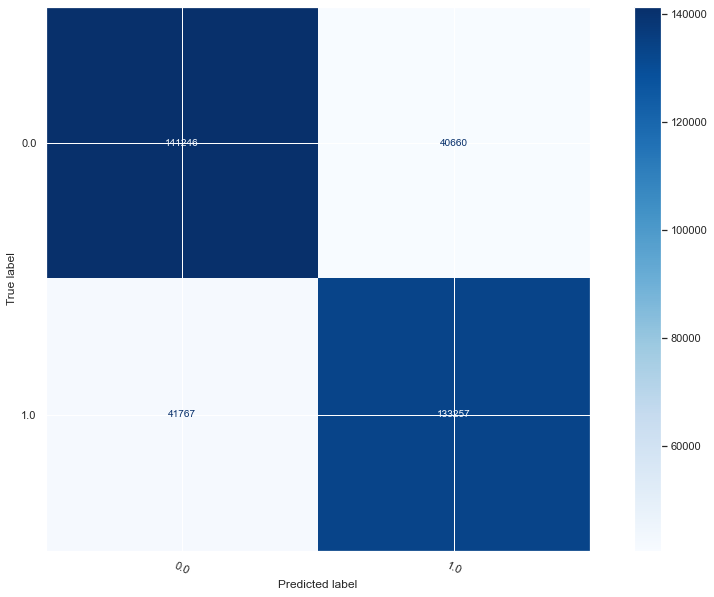

In [37]:
# model = MultinomialNB(alpha=.05)
# model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)

print("Model Accuracy: %f" % accuracy)

fig, ax = plt.subplots(figsize=(16, 10))

disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=model.classes_,
                             cmap=plt.cm.Blues, ax=ax)

plt.xticks(rotation=-25)
disp

In [38]:
# # Saving the vectorizer 
vectorizer.stop_words_ = None
pickle.dump(vectorizer, open('app/models/vectorizer_ngram3.pkl', 'wb') )

# # Saving the model
pickle.dump(model, open('app/models/comments_model_ngram3.pkl', 'wb'))

In [39]:
print(type(vectorizer), type(model))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'> <class 'sklearn.naive_bayes.MultinomialNB'>


In [40]:
my_sentences = [
"""hello, my name is kukai and do you want to talk about the one and only god, thighs""",
"""I hate you you should delete your twitter account""",
"""thanks for the recent support.  :)""",
"""imagine being called a CONTENT CREATOR with people donating $5 for everything""",
"cafeteria has new good fries",
" I hate the new cafeteria french fries",
"fuck"
]

for sentence in my_sentences:
    print(sentence)
    # 1. Apply the text pipeline to your sentence
    input_text = text_pipeline2(sentence)
    # 2. Transform your cleaned text using the `X = vectorizer.transform([your_text])`\
    input_vec = vectorizer.transform([input_text])
    # 3. Use the model to predict your new `X`. 
    model.predict(input_vec)
    # 4. Print the prediction
    pp = model.predict_proba(input_vec)
    p_val = []
    for c, p in zip(model.classes_, pp.round(3)[0]):
        p_val.append(p)
        print(c, p)
    if p_val[0] > 0.65:
        print("REJECT")
    elif p_val[1] > 0.65:
        print("ACCEPT")
    else:print("meh, indecisive?")
    

hello, my name is kukai and do you want to talk about the one and only god, thighs
0.0 0.36
1.0 0.64
meh, indecisive?
I hate you you should delete your twitter account
0.0 0.725
1.0 0.275
REJECT
thanks for the recent support.  :)
0.0 0.132
1.0 0.868
ACCEPT
imagine being called a CONTENT CREATOR with people donating $5 for everything
0.0 0.359
1.0 0.641
meh, indecisive?
cafeteria has new good fries
0.0 0.27
1.0 0.73
ACCEPT
 I hate the new cafeteria french fries
0.0 0.721
1.0 0.279
REJECT
fuck
0.0 0.717
1.0 0.283
REJECT


In [58]:
#X is the input

counter = 0
threshold = 30000

good_dict = dict()
bad_dict = dict()
indecisive_dict = dict()

good_counter = 0
bad_counter = 0
indecisive_counter = 0

good_examples = []
bad_examples = []
indecisive_examples = []

dataset =  df["clean_comment"].values

for sentence in dataset:
    counter +=1
    if counter > threshold:
        break
    #print(sentence)
    # 1. Apply the text pipeline to your sentence
    input_text = text_pipeline2(sentence)
    # 2. Transform your cleaned text using the `X = vectorizer.transform([your_text])`\
    input_vec = vectorizer.transform([input_text])
    # 3. Use the model to predict your new `X`. 
    model.predict(input_vec)
    # 4. Print the prediction
    pp = model.predict_proba(input_vec)
    p_val = []
    for c, p in zip(model.classes_, pp.round(3)[0]):
        p_val.append(p)
        #print(c, p)
    if p_val[0] > 0.65:
        #print("REJECT")
        bad_counter+=1
        if bad_counter < 100:
            bad_examples.append(sentence)
        for word in sentence.split():
            bad_dict[word] = bad_dict.get(word, 0) + 1
        
    elif p_val[1] > 0.65:
        #print("ACCEPT")
        good_counter+=1
        if good_counter < 100:
            good_examples.append(sentence)
        for word in sentence.split():
            good_dict[word] = good_dict.get(word, 0) + 1
    else:
        #print("meh, indecisive?")
        indecisive_counter+=1
        if indecisive_counter < 100:
            indecisive_examples.append(sentence)
        for word in sentence.split():
            indecisive_dict[word] = indecisive_dict.get(word, 0) + 1

print("done")

done


In [59]:
examples = random.sample(good_examples, 5)

for texts in examples:
    print(texts)
    print( "*"*20)

many flavours buddhism pure land ideas common however important thing realize really matter big difference compared abrahamic religions buddhism dogmatic sense bunch things must taken literally else non believer sinner whatever maybe pure land ideas work great maybe great works works work useless historical buddha taught dramatically different styles suit audience parables metaphors point take literally believing literally physically true zen koans good example purely distilled form stories stories believe physically happened reading history book entirely irrelevant story point wondering really happen place really exist missing point also worth noting things psychological phenomenon physical phenomenon personally find makes buddhist cosmology much easier understand considering competitor physical cosmology conflict different cosmos
********************
buddhism much lot compatible christianity especially considering sin suffering almost thing suffering caused wanting things want going 

In [60]:
examples = random.sample(bad_examples, 5)

for texts in examples:
    print(texts)
    print( "*"*20)

holy shit pacific rim
********************
wish money
********************
mindless congress supporter till 2009 became pro bjp pro rss since 2010
********************
vote kanaka jpg cut
********************
always hear modi comes gujarat politics less unknown politicians know
********************


In [61]:
examples = random.sample(indecisive_examples, 5)

for texts in examples:
    print(texts)
    print( "*"*20)


********************
modi claim rescue 15000 people far know government organized transportation gujarat plane road judging reports coming uttarakhand survivors raped looted goons say right thing pulling gujaratis soon possible least suffer relief camps mercy state government food water
********************
arteta shocker
********************
scheduled castes day marriage parties awesome get drunk dance like crazy plays songs god knows languages dance crazy closer foreign clubs starts around 10pm goes till 4am minutes friends didnt wanted stay girls guys ages around midnight youngsters mostly singles left dancing heard khet fuck like crazy party see part recorded video took pictures fucking lost iphone5
********************
tea partier expresses support namo eating idli sambar conservative indian american group indiatribune com submitted minutes ago ladki realize hate modi showed casual racism idli sambhar snide remark another thought fuck
********************


In [62]:
# finding the most frequent words

sorted_good = sorted(good_dict.items(), key=lambda kv: kv[1])
print(type(sorted_good))
print("# of words", len(good_dict))
sorted_good[-20:]

<class 'list'>
# of words 25236


[('much', 702),
 ('right', 728),
 ('see', 750),
 ('time', 793),
 ('well', 799),
 ('also', 828),
 ('best', 843),
 ('team', 845),
 ('even', 860),
 ('free', 862),
 ('get', 870),
 ('think', 939),
 ('would', 1165),
 ('modi', 1215),
 ('one', 1281),
 ('bjp', 1314),
 ('like', 1647),
 ('people', 1849),
 ('india', 1856),
 ('good', 2141)]

<AxesSubplot:title={'center':'Most Frequent Words in Good Comments'}, xlabel='Frequency', ylabel='Common_Good_Words'>

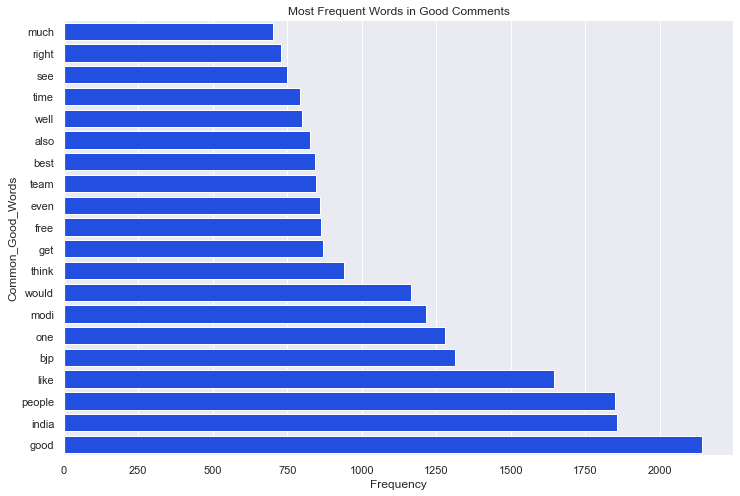

In [64]:
good_df = pd.DataFrame(sorted_good[-20:], columns = ['Common_Good_Words', 'Frequency'])
# good_df.head()

fig, ax = plt.subplots(figsize=(12,8))

sns.set_color_codes("bright")
goodplot = sns.barplot(x="Frequency", y="Common_Good_Words", data=good_df,
             color="b", )
goodplot.set_title("Most Frequent Words in Good Comments")

goodplot

In [65]:
sorted_med = sorted(indecisive_dict.items(), key=lambda kv: kv[1])
print("# of words", len(indecisive_dict))
sorted_med[-20:]

# of words 29212


[('country', 640),
 ('know', 693),
 ('right', 697),
 ('see', 703),
 ('government', 746),
 ('also', 751),
 ('indian', 802),
 ('time', 829),
 ('’', 836),
 ('think', 850),
 ('congress', 860),
 ('get', 1019),
 ('even', 1020),
 ('would', 1141),
 ('one', 1302),
 ('modi', 1824),
 ('like', 1829),
 ('india', 1967),
 ('bjp', 2025),
 ('people', 2046)]

<AxesSubplot:title={'center':'Most Frequent Words in Indecisive Comments'}, xlabel='Frequency', ylabel='Common_Mid_Words'>

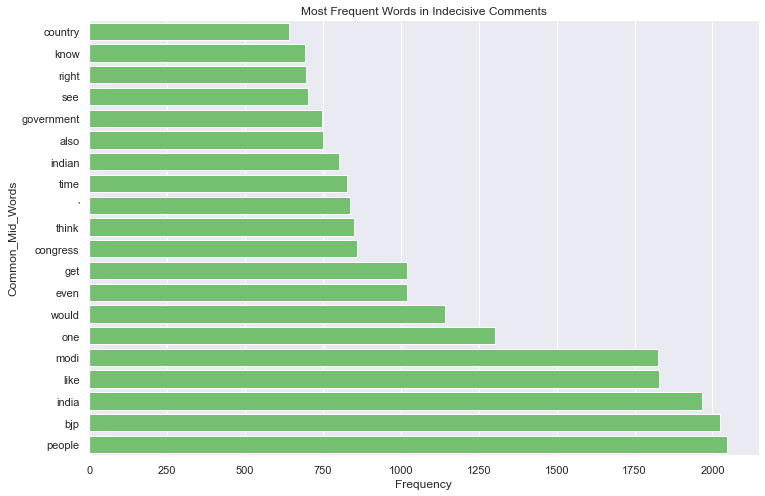

In [66]:
# Creating the barplot for middile words

med_df = pd.DataFrame(sorted_med[-20:], columns = ['Common_Mid_Words', 'Frequency'])
# med_df.head()

fig, ax = plt.subplots(figsize=(12,8))

sns.set_color_codes("muted")
midplot = sns.barplot(x="Frequency", y="Common_Mid_Words", data=med_df,
             color="g", )
midplot.set_title("Most Frequent Words in Indecisive Comments")

midplot


In [67]:
sorted_bad = sorted(bad_dict.items(), key=lambda kv: kv[1])
print("# of words", len(bad_dict))
sorted_bad[-20:]

# of words 23417


[('’', 333),
 ('hai', 355),
 ('shit', 375),
 ('non', 380),
 ('congress', 380),
 ('fuck', 402),
 ('thing', 409),
 ('would', 417),
 ('government', 429),
 ('time', 430),
 ('lot', 445),
 ('get', 514),
 ('che', 518),
 ('even', 545),
 ('one', 620),
 ('india', 677),
 ('like', 789),
 ('people', 907),
 ('bjp', 951),
 ('modi', 1007)]

<AxesSubplot:title={'center':'Most Frequent Words in Bad Comments'}, xlabel='Frequency', ylabel='Common_Bad_Words'>

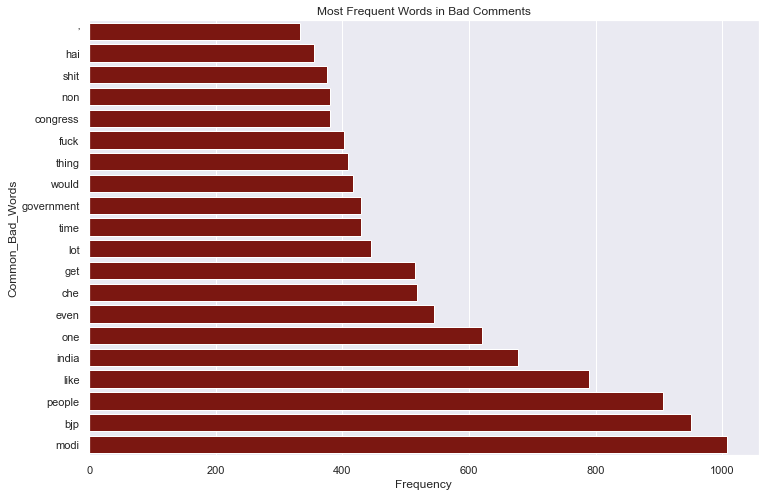

In [68]:
# Creating a bar plot for the sorted_bad words
bad_df = pd.DataFrame(sorted_bad[-20:], columns = ['Common_Bad_Words', 'Frequency'])
# bad_df.head()

fig, ax = plt.subplots(figsize=(12,8))

sns.set_color_codes("dark")
badplot = sns.barplot(x="Frequency", y="Common_Bad_Words", data=bad_df,
             color="r", )
badplot.set_title("Most Frequent Words in Bad Comments")

badplot